**Задание:**  
1. Изучить статью о RNN по ссылке: https://nuancesprog.ru/p/6417/ в том числе изучить описание датасета, который используется в данной статье.
2. Реализовать на основе кода, представленного в статье, графовую рекурентную нейросеть, используя в качестве датасета текст в виде графа.

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [ ]:
import re
import torch
from collections import Counter
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GatedGraphConv
import numpy as np
import random
from collections import deque

In [ ]:
with open('меладзе.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
def clean_text(text):
    # Удаляем лишние пробелы и переносы строк
    text = re.sub(r'\n+', '\n', text).strip()
    return text

In [ ]:
cleaned_text = clean_text(text)
print(cleaned_text[:200])

Не тревожь мне душу, скрипка,
Я слезы не удержу,
Не томи меня своей печалью.
Грусть-тоску мою с тобою
Ни за что не разделю,
Всю ее себе оставлю.
Юных лет хмельная дева
Помахала мне вослед,
От меня к д


In [ ]:
def build_cooccurrence_graph(text, window_size=3):
    sentences = [s for s in re.split(r'[.!?]', text) if len(s) > 0]
    words = []
    for sentence in sentences:
        words.extend([w.lower() for w in re.findall(r'\w+', sentence) if len(w) > 2])

    word_counts = Counter(words)
    vocab = {word: idx for idx, word in enumerate(word_counts.keys())}

    G = nx.Graph()

    for word in vocab:
        G.add_node(word)

    for sentence in sentences:
        sentence_words = [w.lower() for w in re.findall(r'\w+', sentence) if len(w) > 2 and w.lower() in vocab]
        for i in range(len(sentence_words)):
            for j in range(i+1, min(i+window_size+1, len(sentence_words))):
                word1, word2 = sentence_words[i], sentence_words[j]
                if G.has_edge(word1, word2):
                    G[word1][word2]['weight'] += 1
                else:
                    G.add_edge(word1, word2, weight=1)

    return G, vocab

graph, vocab = build_cooccurrence_graph(cleaned_text)
print(f"Граф содержит {len(graph.nodes)} узлов и {len(graph.edges)} ребер")

Граф содержит 460 узлов и 1592 ребер


In [ ]:
# Выбираем граф для визуализации (25 самых частых слов)
top_words = sorted(vocab.keys(), key=lambda x: -sum(d['weight'] for _, _, d in graph.edges(x, data=True)))[:25]
subgraph = graph.subgraph(top_words)

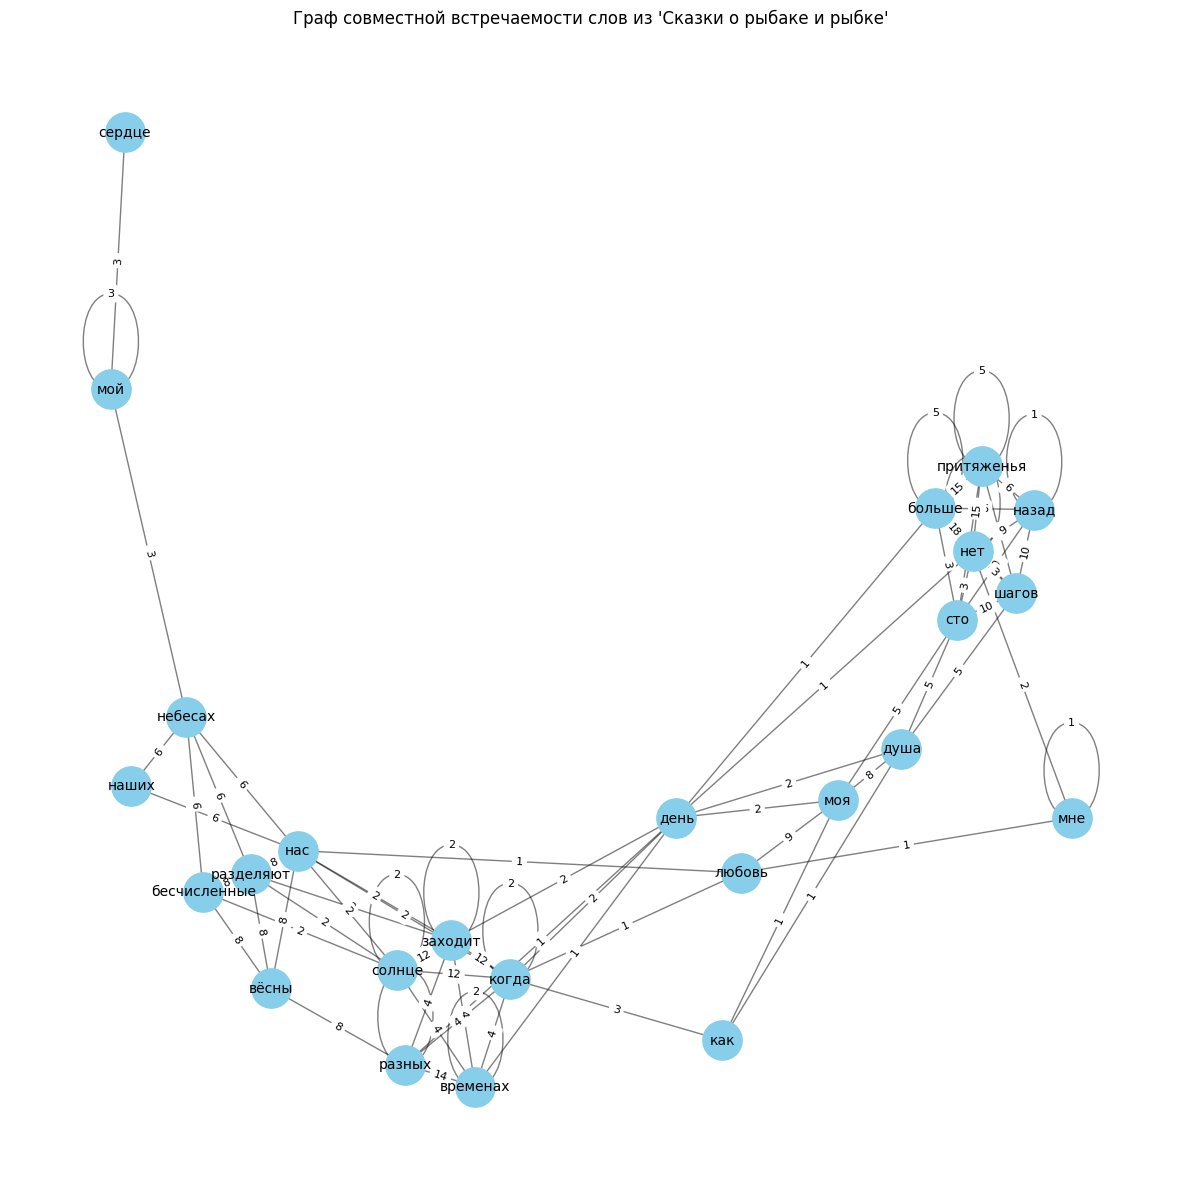

In [ ]:
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(subgraph, k=0.5)
nx.draw_networkx_nodes(subgraph, pos, node_size=800, node_color='skyblue')
nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=10)
edge_labels = {(u, v): d['weight'] for u, v, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)
plt.title("Граф совместной встречаемости слов из 'Сказки о рыбаке и рыбке'")
plt.axis('off')
plt.show()

In [ ]:
class GraphRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(GraphRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.gcn = GatedGraphConv(hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, edge_index, edge_weight=None):
        # x - узлы графа (индексы слов)
        # edge_index - связи между узлами

        x_embed = self.embedding(x)

        out_rnn, _ = self.gru(x_embed.unsqueeze(0))

        # Обработка GNN (графовая)
        out_gnn = self.gcn(out_rnn.squeeze(0), edge_index, edge_weight)

        # Предсказание следующего слова
        out = self.fc(out_gnn)

        return F.log_softmax(out, dim=1)

In [ ]:
# Подготовка данных для PyTorch Geometric
def prepare_graph_data(graph, vocab):
    word_to_idx = vocab

    # Подготовка узлов
    nodes = list(graph.nodes())
    x = torch.tensor([word_to_idx[node] for node in nodes], dtype=torch.long)

    # Подготовка ребер
    edges = list(graph.edges())
    edge_index = torch.tensor([
        [word_to_idx[u], word_to_idx[v]] for u, v in edges
    ], dtype=torch.long).t().contiguous()

    # Веса ребер
    edge_weight = torch.tensor([graph[u][v]['weight'] for u, v in edges], dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

    return data, nodes

In [ ]:
# Преобразуем граф в формат PyTorch Geometric
graph_data, node_names = prepare_graph_data(graph, vocab)

In [ ]:
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
num_layers = 2

In [ ]:
model = GraphRNN(vocab_size, embedding_dim, hidden_dim, num_layers)

In [ ]:
output = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([460, 460])


In [ ]:
# Функция для предсказания похожих слов
def predict_similar_words(model, graph_data, node_names, target_word, top_k=5):
    word_to_idx = {word: idx for idx, word in enumerate(node_names)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    if target_word not in word_to_idx:
        return f"Слово '{target_word}' не найдено в словаре"

    # Получаем предсказания модели
    with torch.no_grad():
        model.eval()
        output = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)

    # Получаем предсказания для целевого слова
    target_idx = word_to_idx[target_word]
    probs = output[target_idx]

    # Находим топ-K самых вероятных слов
    top_probs, top_indices = torch.topk(probs, k=top_k+1)

    result = []
    for prob, idx in zip(top_probs, top_indices):
        word = idx_to_word[idx.item()]
        if word != target_word:
            result.append((word, torch.exp(prob).item()))

    return result[:top_k]

target_word = "любовь"
similar_words = predict_similar_words(model, graph_data, node_names, target_word)
print(f"Слова, наиболее связанные с '{target_word}':")
for word, prob in similar_words:
    print(f"{word}: {prob:.4f}")

Слова, наиболее связанные с 'любовь':
так: 0.0044
зачем: 0.0043
чистом: 0.0041
горя: 0.0040
вчера: 0.0039


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    output = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
    loss = criterion(output, graph_data.x)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 6.1420135498046875
Epoch 1, Loss: 6.070746421813965
Epoch 2, Loss: 5.866105556488037
Epoch 3, Loss: 5.521032333374023
Epoch 4, Loss: 5.251463890075684
Epoch 5, Loss: 4.823907375335693
Epoch 6, Loss: 4.360432147979736
Epoch 7, Loss: 3.928661584854126
Epoch 8, Loss: 3.4108450412750244
Epoch 9, Loss: 2.934784412384033
Epoch 10, Loss: 2.473050117492676
Epoch 11, Loss: 2.0678210258483887
Epoch 12, Loss: 1.6757339239120483
Epoch 13, Loss: 1.3711562156677246
Epoch 14, Loss: 1.105455994606018
Epoch 15, Loss: 0.9072372317314148
Epoch 16, Loss: 0.7462922930717468
Epoch 17, Loss: 0.6083623766899109
Epoch 18, Loss: 0.509326159954071
Epoch 19, Loss: 0.4265303313732147
Epoch 20, Loss: 0.35298991203308105
Epoch 21, Loss: 0.2942834496498108
Epoch 22, Loss: 0.24381814897060394
Epoch 23, Loss: 0.20224130153656006
Epoch 24, Loss: 0.16610397398471832
Epoch 25, Loss: 0.13927190005779266
Epoch 26, Loss: 0.11591348052024841
Epoch 27, Loss: 0.09685608744621277
Epoch 28, Loss: 0.0809383094310760

In [ ]:
class TextGenerator:
    def __init__(self, model, graph_data, node_names, max_length=10):
        self.model = model
        self.graph_data = graph_data
        self.node_names = node_names
        self.max_length = max_length
        self.word_to_idx = {word: idx for idx, word in enumerate(node_names)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}

    def generate(self, starting_word=None, temperature=1.0):

        if starting_word is None:
            current_word = random.choice(self.node_names)
        else:
            current_word = starting_word.lower()
            if current_word not in self.word_to_idx:
                current_word = random.choice(self.node_names)

        generated_text = [current_word]
        used_indices = {self.word_to_idx[current_word]}
        current_idx = self.word_to_idx[current_word]

        for _ in range(self.max_length - 1):
            with torch.no_grad():
                self.model.eval()
                output = self.model(self.graph_data.x,
                                 self.graph_data.edge_index,
                                 self.graph_data.edge_attr)

            word_weights = output[current_idx].div(temperature).exp()

            # Обнуляем веса уже использованных слов
            for used_idx in used_indices:
                word_weights[used_idx] = 0

            # Если все слова уже использованы, начинаем сначала
            if word_weights.sum() == 0:
                word_weights = output[current_idx].div(temperature).exp()
                used_indices = set()

            # Выбираем следующее слово
            next_idx = torch.multinomial(word_weights, 1).item()
            next_word = self.idx_to_word[next_idx]

            # Обновляем состояние
            generated_text.append(next_word)
            used_indices.add(next_idx)
            current_idx = next_idx
            if next_word in ['.', '!', '?'] and len(generated_text) > 3:
                break

        text = ' '.join(generated_text).capitalize()
        if text[-1] not in ['.', '!', '?']:
            text += '.'
        text = re.sub(r'\s+([,.!?])', r'\1', text)
        text = re.sub(r'\s+', ' ', text)

        return text

generator = TextGenerator(model, graph_data, node_names, max_length=10)
print("Примеры сгенерированного текста:")
for _ in range(5):
    print(generator.generate(starting_word="любовь"))

Примеры сгенерированного текста:
Любовь моя бредет сто шагов назад оставайся пальцах тихо лети.
Любовь живет края утру вокруг лимбо звали странно скучаю будто.
Любовь моя душа понуро бредет небе белый лебедь надо падал.
Любовь моя душа была она отчаянно красива ушла зима кончилась.
Любовь моя живет где края сон хранить беды сны видишь.


In [ ]:
generator.generate(starting_word="любовь")

'Любовь моя бредет понуро тобой была близка лишь миновать вовек.'

In [ ]:
generator.generate(starting_word="как")

'Как растаял голубой дали дым руками трижды разведу горы сыграю.'